|batch_size |  1            |   32          |       64  |
|---        |--             |    --         | --        |
|nfv        | 174.62+16.25  |  178.1+10.64  |           |
|vec-nfv    | 173.42+14.94  |  173.98+2.65  |174.16+2.09| 

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from configs.ve import cifar10_ncsnpp_continuous as configs
from sde_lib import VESDE
from models import ncsnpp
from env import RK45Env
import models.utils as mutils
import torch
import numpy as np
import sampling
import datasets
from utils import restore_checkpoint
from models.ema import ExponentialMovingAverage
from losses import get_optimizer

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img[:w*w].reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


ckpt_filename = "exp/ve/cifar10_ncsnpp_continuous/checkpoint_24.pth"
config = configs.get_config()  
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
score_model = mutils.create_model(config)
optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
d:\myproject\score_sde_pytorch\utils.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037812028..1.024299].


170.1875


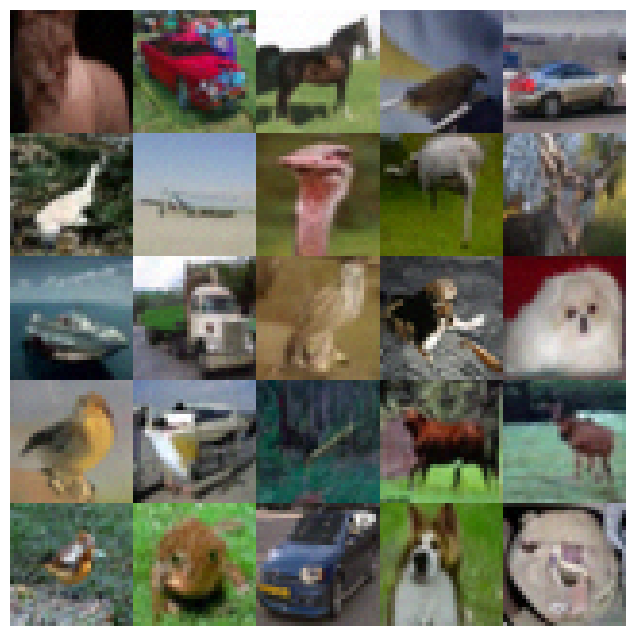

In [9]:
env = RK45Env(
    sde=sde, 
    model=score_model, 
    env_num=32, 
    device=torch.device("cuda"), 
    compute_logp=False,
    use_opt=True, 
    compute_opt=False
)
# a = torch.randn(1, 3, 32, 32)
# torch.save(a, "z.pt")
out = env.sample()
print(out["nfev"].mean().item())
show_samples(out["z"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0346419..1.0300233].


mean nfev: 174.16625+2.090617432721731


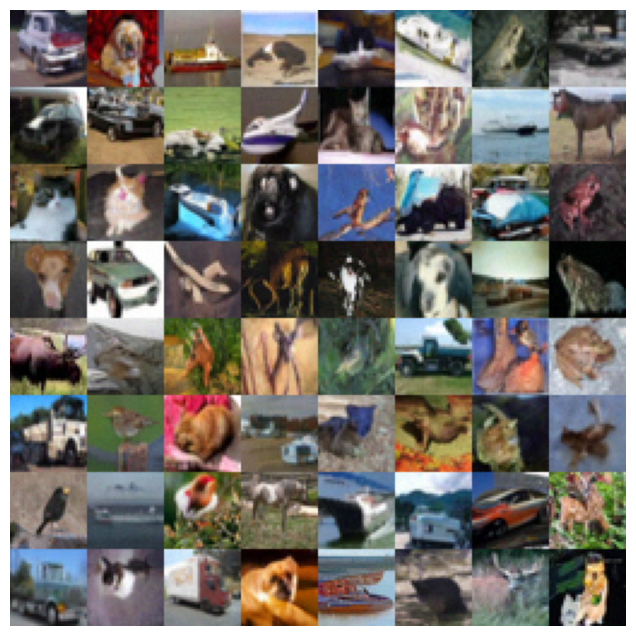

In [5]:
env = RK45Env(
    sde=sde, 
    model=score_model, 
    env_num=64, 
    device=torch.device("cuda"), 
    compute_logp=False,
    use_opt=True, 
    compute_opt=False
)
def cb(env, td):
    # print(f"nfev: {env.nfev.mean().item()}, done: {td["done"].sum().item()}, rejected: {td["step_rejected"].sum().item()}")
    pass
nfevs = []
for i in range(100):
    td = env.sample(cb)
    nfevs.append(td["nfev"].mean().item())
print(f"mean nfev: {np.mean(nfevs)}+{np.std(nfevs)}") # 185.3
show_samples(td["z"])

In [4]:
shape = (32, 3, 32, 32)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
sampling_eps = 1e-5

sampling_fn = sampling.get_ode_sampler(sde,                                        
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
nfevs = []
for i in range(100):
    x, nfe = sampling_fn(score_model)
    nfevs.append(nfe)
print(f"mean nfev: {np.mean(nfevs)}+{np.std(nfevs)}") # 174.62+16.252249075128034
# show_samples(x)

mean nfev: 178.1+10.644716999526104


In [39]:
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
sampling_eps = 1e-5

sampling_fn = sampling.get_ode_sampler(sde,                                        
                                       (1, 3, 32, 32), 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
x, nfe = sampling_fn(score_model)
print(nfe)

D:\myproject\score_sde_pytorch\sde_lib.py:239: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  # return torch.load('z.pt') * self.sigma_max


0.9489790067248123 1.0
0.9439502450250087 0.9988261104121553
0.9344869719574626 0.9966170501336858
0.9280737746688373 0.9949255752005288
0.8949804457869927 0.9864682005347434
0.8881641998325716 0.984964667260826
0.8809798822126916 0.9830852506684292
0.8828903279520159 0.9830852506684292
0.8675998471547267 0.9788513908240641
0.8604780485303577 0.9767344609018815
0.8256122047896981 0.9661498112909687
0.8197935265897612 0.9642680958045842
0.8125617917450753 0.9619159514466036
0.8125113222930903 0.9619159514466036
0.7973404583274023 0.9568846672004944
0.790600095263223 0.9543690250774398
0.7570874073627142 0.9417908144621668
0.7510496865081612 0.9395546881305628
0.7441495206333107 0.9367595302160576
0.7448450865235126 0.9367595302160576
0.7324760498188803 0.9316212048321931
0.7270806094651944 0.9290520421402609
0.6982755488254258 0.9162062286805999
0.690103594695489 0.9139225285099934
0.6847905662195587 0.9110679032967354
0.6900005716240415 0.9110679032967354
0.6798887073565053 0.905686299